# 1. Install Dependencies and Setup

In [2]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [3]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.3.0
aiohttp                       3.8.1
aiosignal                     1.2.0
alabaster                     0.7.12
anaconda-client               1.9.0
anaconda-navigator            2.2.0
anaconda-project              0.10.2
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.6.6
astropy                       5.0.4
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout                 4.0.1
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backpor

In [4]:
import tensorflow as tf
import os

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [7]:
import cv2
import imghdr

In [8]:
data_dir = 'data' 

In [9]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [10]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 9341 files belonging to 2 classes.


In [13]:
data_iterator = data.as_numpy_iterator()

In [14]:
batch = data_iterator.next()

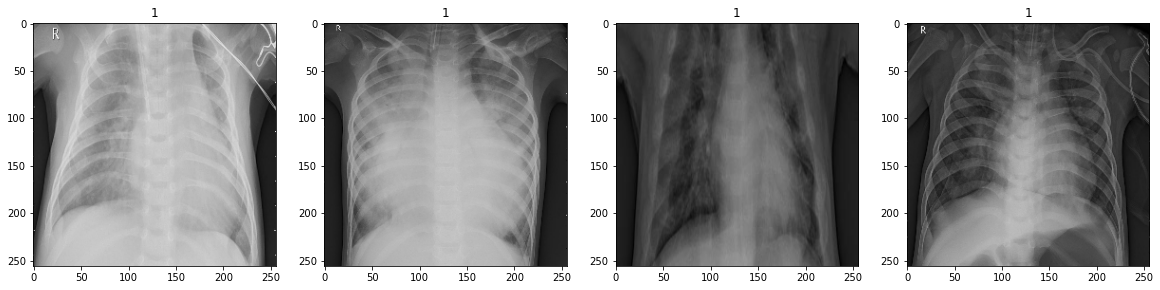

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [16]:
data = data.map(lambda x,y: (x/255, y))

In [17]:
data.as_numpy_iterator().next()

(array([[[[0.04313726, 0.04313726, 0.04313726],
          [0.04093137, 0.04093137, 0.04093137],
          [0.03529412, 0.03529412, 0.03529412],
          ...,
          [0.16522288, 0.16522288, 0.16522288],
          [0.17616038, 0.17616038, 0.17616038],
          [0.17610294, 0.17610294, 0.17610294]],
 
         [[0.04313726, 0.04313726, 0.04313726],
          [0.04093137, 0.04093137, 0.04093137],
          [0.03529412, 0.03529412, 0.03529412],
          ...,
          [0.15257353, 0.15257353, 0.15257353],
          [0.1629902 , 0.1629902 , 0.1629902 ],
          [0.1764706 , 0.1764706 , 0.1764706 ]],
 
         [[0.03529412, 0.03529412, 0.03529412],
          [0.02965686, 0.02965686, 0.02965686],
          [0.0302811 , 0.0302811 , 0.0302811 ],
          ...,
          [0.1557713 , 0.1557713 , 0.1557713 ],
          [0.16474801, 0.16474801, 0.16474801],
          [0.1682598 , 0.1682598 , 0.1682598 ]],
 
         ...,
 
         [[0.00392157, 0.00392157, 0.00392157],
          [0.00392

# 5. Split Data

In [18]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [19]:
train_size

204

In [20]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [21]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [23]:
model = Sequential()

In [24]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [25]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [27]:
logdir='logs'

In [28]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [29]:
hist = model.fit(train, epochs=9, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/9
204/204 [==============================] - 176s 859ms/step - loss: 0.2338 - accuracy: 0.9066 - val_loss: 0.1389 - val_accuracy: 0.9520
Epoch 2/9
204/204 [==============================] - 174s 848ms/step - loss: 0.1222 - accuracy: 0.9576 - val_loss: 0.1194 - val_accuracy: 0.9628
Epoch 3/9
204/204 [==============================] - 174s 849ms/step - loss: 0.1067 - accuracy: 0.9606 - val_loss: 0.0761 - val_accuracy: 0.9709
Epoch 4/9
204/204 [==============================] - 170s 830ms/step - loss: 0.0785 - accuracy: 0.9718 - val_loss: 0.0930 - val_accuracy: 0.9650
Epoch 5/9
204/204 [==============================] - 168s 821ms/step - loss: 0.0766 - accuracy: 0.9724 - val_loss: 0.0804 - val_accuracy: 0.9714
Epoch 6/9
204/204 [==============================] - 171s 836ms/step - loss: 0.0565 - accuracy: 0.9812 - val_loss: 0.0784 - val_accuracy: 0.9714
Epoch 7/9
204/204 [==============================] - 173s 844ms/step - loss: 0.0373 - accuracy: 0.9871 - val_loss: 0.1071 - val_ac

# 8. Plot Performance

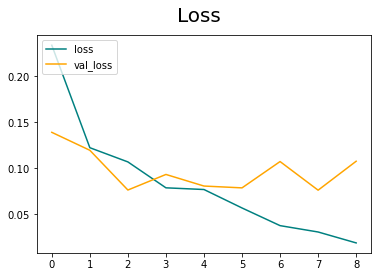

In [30]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

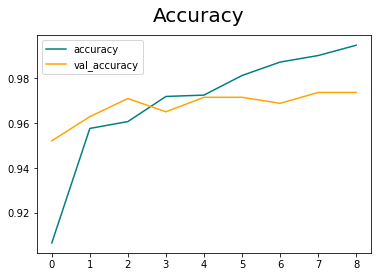

In [31]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [32]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [33]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [34]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 208ms/step


In [35]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.9745223, shape=(), dtype=float32) tf.Tensor(0.9832905, shape=(), dtype=float32) tf.Tensor(0.96443963, shape=(), dtype=float32)


# 10. Test

In [36]:
import cv2

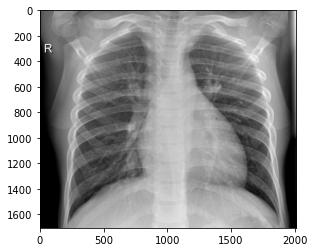

In [65]:
img = cv2.imread('NORMAL2-IM-0381-0001.jpeg')
plt.imshow(img)
plt.show()

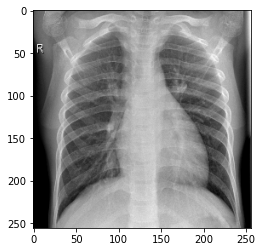

In [66]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [67]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 34ms/step


In [68]:
yhat

array([[0.4268897]], dtype=float32)

In [70]:
if yhat > 0.5: 
    print(f'Predicted class is pneumonia')
else:
    print(f'Predicted class is normal')

Predicted class is normal


# 11. Save the Model

In [71]:
from tensorflow.keras.models import load_model

In [76]:
model.save(os.path.join('models','imageclassifier.h5'))

In [77]:
new_model = load_model('imageclassifier.h5')

OSError: No file or directory found at imageclassifier.h5

In [78]:
new_model.predict(np.expand_dims(resize/255, 0))

NameError: name 'new_model' is not defined